# CryptoNet implementation and training on MNIST dataset

In [25]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from torch.utils.tensorboard import SummaryWriter
import math


Model

In [ ]:
## DUMMY MODEL
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output  # return x for visualization

In [39]:
class ScaledAvgPool2d(nn.Module):
    """Define the ScaledAvgPool layer, a.k.a the Sum Pool"""
    def __init__(self,kernel_size):
      super().__init__()
      self.kernel_size = kernel_size
      self.AvgPool = nn.AvgPool2d(kernel_size=self.kernel_size, stride=1, padding=1)

    def forward(self,x):
      return (self.kernel_size**2)*self.AvgPool(x)
    

class CryptoNet(nn.Module):
  '''
    TO DO: check how in the paper the avg pool does not downscale the input size...weird padding?
    EDIT: probably yes, it's a same convolution
  '''
  def __init__(self, verbose):
    super().__init__()
    self.verbose = verbose
    self.pad = F.pad
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=2)
    self.square1 = torch.square
    self.scaledAvgPool1 = ScaledAvgPool2d(kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=50, kernel_size=5, stride=2)
    self.scaledAvgPool2 = ScaledAvgPool2d(kernel_size=3)
    self.fc1 = nn.Linear(in_features=1250, out_features=100) # in paper in_features was 1250
    self.square2 = torch.square
    self.fc2 = nn.Linear(in_features=100, out_features=10)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.pad(x, (1,0,1,0))
    if self.verbose:
      print("Start --> ",x.mean())
    x = self.conv1(x)
    if self.verbose:
      print("Conv1 --> ",x.mean())
    x = self.square1(x)
    if self.verbose:
      print("Sq --> ",x.mean())
    x = self.scaledAvgPool1(x)
    if self.verbose:
      print("Pool --> ",x.mean())
    x = self.conv2(x)
    if self.verbose:
      print("Conv2 --> ",x.mean())
    x = self.scaledAvgPool2(x)
    if self.verbose:
      print("Pool --> ",x.mean())
    ## Flatten
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    if self.verbose:
      print("fc1 --> ",x.mean())
    x = self.square2(x)
    if self.verbose:
      print("Square --> ",x.mean())
    x = self.fc2(x)
    if self.verbose:
      print("fc2 --> ",x.mean())
    x = self.sigmoid(x)
    return x

  def weights_init(self, m):
    """ Custom initilization to avoid square activation to blow up """
    for m in self.children():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
      elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, 1e-4,1e-3)


Load Datasets

In [31]:
class DataHandler():
  def __init__(self, dataset : str):
    if dataset == "MNIST":
      transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
      train_ds = MNIST("data/", train=True, download=True, transform=transform)
      test_ds = MNIST("data/", train=False, download=True)

      self.train_dl = DataLoader(train_ds, batch_size = 256, shuffle=True, drop_last=True)
      self.test_dl = DataLoader(test_ds, batch_size = 256, shuffle=True, drop_last=True)

Plot gradient flow

In [6]:
def plot_grad_flow(named_parameters):
    ## From https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063
    ## Beware it's a little bit tricky to interpret results
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''

    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
            print(f"Layer {n}, grad avg {p.grad.mean()}, data {p.data.mean()}")
    plt.bar(np.arange(len(max_grads)), max(max_grads), alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), np.mean(ave_grads), alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    


Training

Start -->  tensor(0.0074)
Conv1 -->  tensor(0.1108, grad_fn=<MeanBackward0>)
Sq -->  tensor(2.6308, grad_fn=<MeanBackward0>)
Pool -->  tensor(23.2587, grad_fn=<MeanBackward0>)
Conv2 -->  tensor(8.6173, grad_fn=<MeanBackward0>)
Pool -->  tensor(65.5936, grad_fn=<MeanBackward0>)
fc1 -->  tensor(45.7207, grad_fn=<MeanBackward0>)
Square -->  tensor(2315.8179, grad_fn=<MeanBackward0>)
fc2 -->  tensor(125.3483, grad_fn=<MeanBackward0>)
[?] Step 1 Epoch 1
Layer conv1.weight, grad avg 3.4531000281390334e-09, data 0.018138675019145012
Layer conv2.weight, grad avg 2.1051262955040784e-09, data 0.0020927374716848135
Layer fc1.weight, grad avg 4.2409784017927166e-10, data 0.0005501683335751295
Layer fc2.weight, grad avg 2.9257774869506648e-08, data 0.0005407884600572288
Start -->  tensor(-0.0198)
Conv1 -->  tensor(0.0963, grad_fn=<MeanBackward0>)
Sq -->  tensor(2.4360, grad_fn=<MeanBackward0>)
Pool -->  tensor(21.5160, grad_fn=<MeanBackward0>)
Conv2 -->  tensor(7.7303, grad_fn=<MeanBackward0>)
Pool

KeyboardInterrupt: ignored

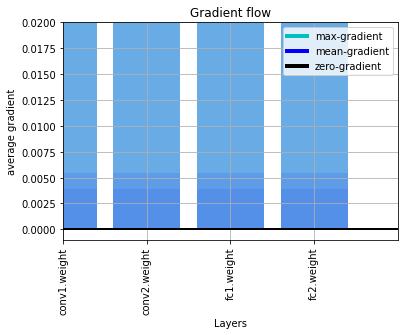

In [41]:
## setup torch enviro
torch.manual_seed(9325345339582034)
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## init model
model = CryptoNet(verbose=True)
model.apply(model.weights_init)
model = model.to(device=device)

dataHandler = DataHandler("MNIST")

## training params setup
learning_rate = 3e-4
momentum = 0.9
num_epochs = 5000
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(dataHandler.train_dl):
    data = data.to(device=device)
    labels = labels.to(device=device)
    #labels = labels.to(torch.float32)

    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions, labels)
    loss.backward()
    if model.verbose:
      print(f"[?] Step {i+1} Epoch {epoch+1}")
      plot_grad_flow(model.named_parameters())
    optimizer.step()

    if (i+1) % 50 == 0:
      print ('[!] Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

torch.save(model, "cryptoNet.pt")

Analysis on this output: I don't understand how come, even if the mean of the input tensor
of the sigmoid is 125, this time the avg grad. is not zero...then it does not depend on the gradient of the sigmoid going to 0 for large outputs?

Dummy Testing, feel free to ignore

Testing

['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0055), tensor(0.0038), tensor(0.0065)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0054), tensor(0.0037), tensor(0.0060)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0063), tensor(0.0039), tensor(0.0060)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0080), tensor(0.0043), tensor(0.0066)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0090), tensor(0.0047), tensor(0.0065)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0138), tensor(0.0054), tensor(0.0082)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0172), tensor(0.0060), tensor(0.0076)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0229), tensor(0.0062), tensor(0.0079)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0239), tensor(0.0062), tensor(0.0082)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0258), tensor(0.0066), tensor(0.0108)]


KeyboardInterrupt: ignored

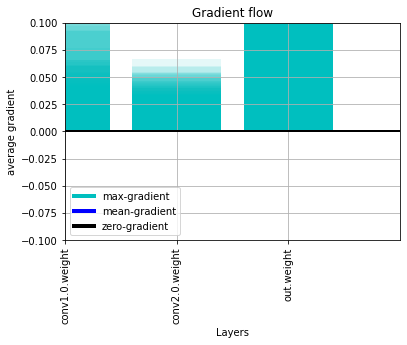

In [ ]:
torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN()

def grad_clipping(model):
  for p in model.parameters():
    p.register_hook(lambda grad: print(grad))
    p.register_hook(lambda grad: torch.clamp(grad, 0, 1.0))

    p.register_hook(lambda grad: print(f"{p} -> {grad}"))

#grad_clipping(model)
model = model.to(device=device)
dataHandler = DataHandler("MNIST")

learning_rate = 0.001
momentum = 0.9
num_epochs = 1
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(dataHandler.train_dl):
    data = data.to(device=device)
    labels = labels.to(device=device)
    #labels = labels.to(torch.float32)

    ## Forward
    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions, labels)
    loss.backward()
    plot_grad_flow(model.named_parameters())
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
torch.save(model, "cryptoNet.pt")